# Goals / Plan

- Using regret for the game works, but is slow
    - choosing 1 random contract per round only, 1 random action per player
    - regret is inaccurance b/c it is based on a random sample from opponent's mixed strategies; imprecise

- How can we apply regret minimization WITHOUT random sampling (use precise probabilities)?

# Symmetric Regret and Convolutions

- example scenario:
    - contract is uniform [700, 1300]
    - contract is N(1000, 150) - bonus
    - 10 players for both

- initializations:
    - realistically, assume nobody is bidding over 200
    - initialize regret of options 1-200 np.zeros(200) --> even probabilities

- calculating regret:
    - assume we have a 200-length probability vector p
    - we want to find the regret of choosing each option based on MIXED STRATEGIES of opponents + CONTRACT PDF
        - this is the key, not using random samples, but exact probabilities

regret of choosing a value x:
- convolution of the other 9 players pdfs over values < x:
    - length x, convolve 9 times --> 9x log(9x)
    - this is the distribution of the sum of other players' lower bids
- how to integrate contract pdf
    - integral of [(contract == c) * (convolution cdf < c - x)]
    - don't calculate integral, do it discrete
    - for uniform distribution, calculate each contract value, then average (600 scenarios)

time complexity of calculating regret for value x:
- convolution takes 9x log (9x) time
- turn pdf into cdf (prefix sum linear time, 9x)
- for each contract scenario, find sum of probabilities (600 time)
- overall: 9x log(9x) * 600

time complexity over all values:
- Sum x=1 to x=200 of (9x log(9x) * 600) = 10^8 about
- Expressed differently: about max x^2 * players * contract length
- Assuming max x is about max(contract) / players * 2
- O(max(contract)^2 * contract length)

change to contract is [350, 650], 10 players (still feels like enough granularity)
- now instead of 10^8, about 10^7 per iteration
- iterations converge much quicker, about 100 iterations maybe?

In [291]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [292]:
def convolve_pdf_n_times(p, n):
    """
    Convolve the discrete pdf `p` with itself `n` times (i.i.d. sum),
    using FFT-based polynomial exponentiation.

    Returns a 1D NumPy array of length len_out = n*(len(p)-1) + 1,
    which is the pmf of the sum of `n` i.i.d. random variables with pmf p.
    """
    p = copy.copy(p)

    # Ensure that it is valid
    # if np.sum(p) > 1.01: p = p / np.sum(p)
    if np.sum(p) < 1: p[0] = 1 - np.sum(p)

    # Length of the original pmf
    M = len(p)
    
    # Output length needed to hold n-fold convolution without wrap-around
    out_len = n*(M-1) + 1
    
    # Next power-of-two (or just next convenient length) for FFT
    # This helps FFT efficiency
    fft_len = 1
    while fft_len < out_len:
        fft_len <<= 1  # multiply by 2
    
    # Zero-pad p to length fft_len
    p_padded = np.zeros(fft_len, dtype=np.float64)
    p_padded[:M] = p
    
    # FFT
    P = np.fft.fft(p_padded)
    
    # Raise to the n-th power, elementwise
    Pn = P ** n
    
    # Inverse FFT
    # The result should be real, but we'll take np.real_if_close just in case
    conv_n = np.fft.ifft(Pn)
    conv_n = np.real_if_close(conv_n, tol=1e5)
    
    # Now conv_n has length fft_len, but we only need the first out_len samples
    conv_n = conv_n[:out_len]
    
    return conv_n

In [297]:
""" 
Variables to define:
    provide own reward function (given the single mixed strategy, # other players) --> calculate the reward
    support space
    number of players
"""
class SymmetricRegret:
    def __init__(self, num_players, support, rewardFunction, **kwargs):
        self.PLAYERS = num_players
        self.ACTIONS = support
        self.rewardFunction = rewardFunction
        self.kwargs = kwargs

        self.regret = np.zeros(len(support))
        self.last_regret = np.zeros(len(support))
    
    def get_strategy(self):
        ceiling = np.maximum(0, self.regret)
        if np.sum(ceiling) == 0: ceiling = np.ones(len(ceiling))
        strategy = ceiling / np.sum(ceiling)
        if np.sum(strategy) > 1.1: print("error here even")
        return strategy
    
    def solve(self, trials, verbose=None):
        for i in range(trials):
            strategy = self.get_strategy()
            current_regret = self.rewardFunction(self.ACTIONS, strategy, self.PLAYERS - 1, **self.kwargs)
            new_regret = self.regret + current_regret

            # Prints and breaks
            if np.isclose(np.maximum(current_regret, 0), 0, atol=1e-3).all():
                print(f"Breaking at iteration {i}")
                break
            if verbose and (i%verbose == 0): print(new_regret)

            self.regret = new_regret
            self.last_regret = current_regret
    
    def output_strategy(self):
        nonzero_actions = []
        for action, probability in zip(self.ACTIONS, self.get_strategy()):
            tol = 1e-4
            if probability < tol: continue
            nonzero_actions.append((action, probability))
        print(nonzero_actions)

In [298]:
def regretFunction(actions, strategy, num_players, contract_distribution):
    assert len(actions) == len(strategy)
    rewards = np.zeros(len(actions))
    zero_padded_strategies = np.concatenate([np.zeros(min(actions)), strategy])

    for i, x in enumerate(actions):
        convolved = convolve_pdf_n_times(zero_padded_strategies[:x+1], num_players) # we always LOSE the ties
        for j in range(len(convolved)-1): convolved[j+1] += convolved[j]

        # find the reward
        probability = 0
        for contract_prob, contract_val in contract_distribution:
            value_threshold = contract_val - x # convolution needs to sum to <= value threshold, for us to get filled
            probability += contract_prob * (convolved[value_threshold] if value_threshold < len(convolved) else 1)

        # rewards
        rewards[i] = probability * x

    avg_reward = rewards * strategy
    regret = rewards - np.sum(avg_reward)
    return regret

In [ ]:
NUM_PLAYERS = 10
ACTIONS = np.arange(30, 200)

lo, hi = 350, 450
contract = [(1/(hi-lo+1), i) for i in range(lo, hi+1)]

r = SymmetricRegret(NUM_PLAYERS, ACTIONS, regretFunction, contract_distribution=contract)
r.solve(1000, verbose=None)
strategy = r.get_strategy()
r.output_strategy()

[(70, 0.619109734359291), (71, 0.3808902656407091)]


<Axes: >

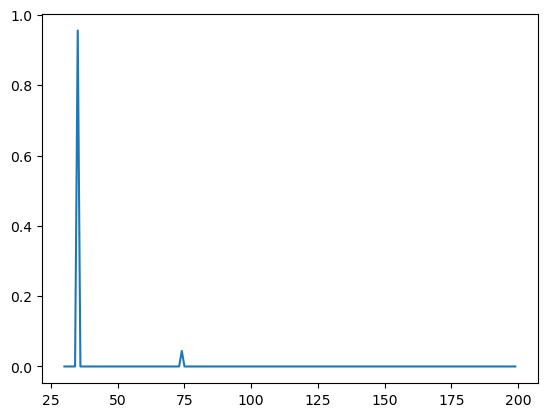

In [166]:
sns.lineplot(x=ACTIONS, y=strategy)

In [296]:
NUM_PLAYERS = 2
ACTIONS = np.arange(1, 11)

lo, hi = 10, 10
contract = [(1/(hi-lo+1), i) for i in range(lo, hi+1)]

r = SymmetricRegret(NUM_PLAYERS, ACTIONS, regretFunction, contract_distribution=contract)
r.solve(1000, verbose=None)
strategy = r.get_strategy()
r.output_strategy()

[(5, 1.0)]


In [280]:
strategy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [285]:
regretFunction(ACTIONS, strategy, 1, contract)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1 [1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0.]
2 [1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0.]
3 [1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0.]
4 [1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0.]
5 [1. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
6 [1. 1. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0.]
7 [1. 1. 1. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0.]
8 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
10 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


array([-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.])